<a href="https://colab.research.google.com/github/tamnhu2913/FasterRCNN/blob/main/RegionProposalNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import userdata

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Load and custom data


*  In this section, the images will be resized into (640,640), along with the ground truth boxes being resized similarly.
\begin{equation}
    scale \_ width = \frac{width\_new}{width\_old} \\
    scale \_ height = \frac{height\_new}{height\_old}
\end{equation}
With, (width\_new, height\_new) is of new size and (width\_old, height\_old) is of the orginal size.

* The shape of :

  * Image sets are (1, H, W, D)
  * Ground Truth Boxes are (M, 4)

  with: B is batch size (equal to 64), W is width, H is height, D is Depth and M is the number of objects; the boxes include x\_min, x\_max, y\_min, y\_max.



In [3]:
def coordinate_to_center(box):
  x_min, x_max, y_min, y_max = box[:,0], box[:,2], box[:,1], box[:,3]
  w = x_max - x_min
  h = y_max - y_min
  x_center = x_min + w/2
  y_center = y_min + h/2
  box = np.vstack((x_center, y_center, w, h))
  return box.T

def center_to_coordinate(box):
  x_center, y_center, w, h = box[:,0], box[:,1], box[:,2], box[:,3]
  x_min = x_center - w/2
  y_min = y_center - h/2
  x_max = x_center + w/2
  y_max = y_center + h/2
  box = np.vstack((x_min, y_min, x_max, y_max))
  return box.T

def custom_data(image, bboxes, new_size):
  width = image.shape[1]
  height = image.shape[0]

  new_image = cv2.resize(image, (new_size[0],new_size[1]))
  new_image = np.expand_dims(new_image / 255.0, axis = 0)

  w_scale = new_size[0] / width
  h_scale = new_size[1] / height
  bboxes = bboxes * [w_scale, h_scale, w_scale, h_scale]
  return np.asarray(new_image), bboxes

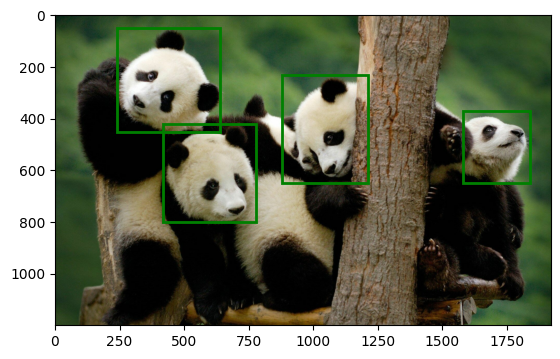

In [4]:
image = cv2.cvtColor(cv2.imread('/content/drive/MyDrive/GYsfzuKacAAgcMo.jpg'), cv2.COLOR_BGR2RGB)
boxes = np.array([[240,50,640,450], [420,420,780,800], [880,230,1210,650],[1580,370,1840,650]])
plt.imshow(image)
for box in boxes:
  rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3] - box[1],
                           linewidth=2, edgecolor='g', facecolor='none')
  plt.gca().add_patch(rect)

plt.show()

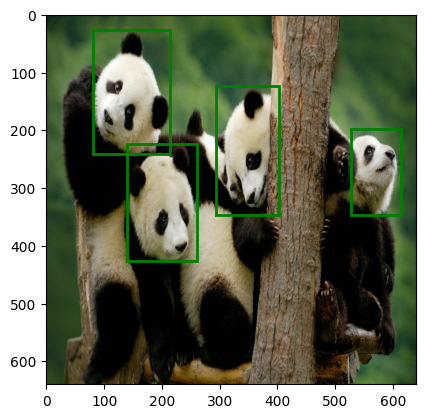

In [5]:
new_size = [640,640]
image, boxes = custom_data(image, boxes, new_size)
plt.imshow(image[0])
for box in boxes:
  rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3] - box[1],
                           linewidth=2, edgecolor='g', facecolor='none')
  plt.gca().add_patch(rect)
plt.show()

# Get the feature map of image and then generate anchor boxes
* The feature map be got by vgg16 model. With the image have size $[640,640]$, the size of feature map are $[40,40]$
* The anchor boxes will generate from scales = $[10,12,32]$ and aspect ratio = $[0.5,1,2]$
* We have:
\begin{equation}
\frac{width}{height} = aspect\_ratio
\end{equation}
* The shape of anchor is $(14400,)$ , since it equal to $width\_feature * hight\_feature * number\_of\_scales*number\_of\_ratios$

In [6]:
def buid_vgg16(shape):
  vgg16 = tf.keras.applications.VGG16(include_top=False, weights = 'imagenet',
                                      input_shape = shape)
  vgg16.trainable = False
  output = vgg16.get_layer('block5_conv3').output
  model = tf.keras.Model(inputs = vgg16.input, outputs = output)
  return model

In [7]:
input_shape = new_size + [3]
backgone_model = buid_vgg16(input_shape)

feature = backgone_model.predict(image)
print('shape of feature: ', feature.shape)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
shape of feature:  (1, 40, 40, 512)


In [8]:
def generate_anchor_boxes(feature_shape, scales, ratios, new_size):
  strid_w = new_size[0] / feature_shape[0]
  strid_h = new_size[1] / feature_shape[1]

  w = np.round(strid_w * np.sqrt(ratios)[None,:] * scales[:, None])
  h = np.round(strid_h / np.sqrt(ratios)[None,:] * scales[:, None])
  base_boxes = np.stack([-w.ravel(), -h.ravel(), w.ravel(), h.ravel()], axis = 1) / 2
  base_boxes = np.round(base_boxes)
  shift_x = np.arange(0, feature_shape[0]) * strid_w #+ strid_w // 2
  shift_y = np.arange(0, feature_shape[1]) * strid_h #+ strid_h // 2
  shift_x, shift_y = np.meshgrid(shift_x, shift_y, indexing='ij')
  shift_x = np.reshape(shift_x, -1)
  shift_y = np.reshape(shift_y, -1)
  shifts = np.stack([shift_x, shift_y, shift_x, shift_y], axis = 1)

  anchors = np.reshape(shifts, (-1,1,4)) + np.reshape(base_boxes, (1,-1,4))
  return anchors.reshape(-1,4)  #xmin, ymin, xmax, ymax

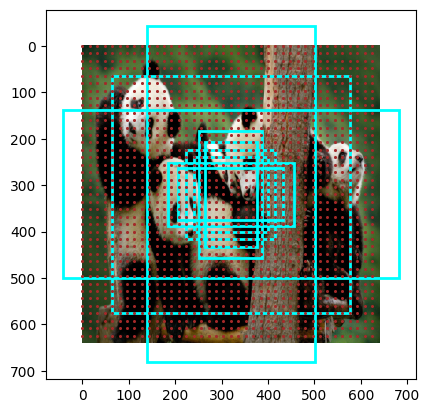

In [26]:
# Draw anchor
scales = np.array([10,12,32])
ratios = np.array([0.5,1,2])
new_size = [640,640]
anchor_boxes = generate_anchor_boxes(feature.shape[1:3], scales, ratios, new_size)

plt.imshow(image[0])

for i,box in enumerate(anchor_boxes):
  x_center = box[0] + (box[2] - box[0])/2
  y_center = box[1] + (box[3] - box[1])/2
  plt.plot(x_center,y_center, marker = 'o', color = 'brown', markersize = 0.5)
  ind = 40 * len(scales)*len(ratios) * 20 + len(scales)*len(ratios) * 20
  if i in np.arange(ind,ind+len(scales)*len(ratios)):
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='cyan',facecolor='none')
    plt.gca().add_patch(rect)
plt.show()

# Create data for RPN model



1.  The first, I generate anchor boxes by scales and ratios
2.   From those anchor boxes, I define a label matrix of background and foreground. If the $\text{IoU of each boxes} < 0.3$ then the label $= -1$ (background), $0.3 \leq \text{IoU} < 0.7$ then the label $ = -2 $ (ignored) and for others, it is set accordingly. Additionally, I define a new box matrix that contains the ground truth boxes with the best IoU for each anchor box.
3.  I transform the new matrix onto regression boxes:
\begin{align}
  Δx = \frac{x_{gt} - x_{anc}}{w_{anc}}, \hspace{1cm} Δy = \frac{y_{gt} - y_{anc}}{h_{anc}},
\end{align}

\begin{align}
  Δw = \log{\frac{w_{gt}}{w_{anc}}}, \hspace{1cm} Δh = \log{\frac{h_{gt}}{h_{anc}}}.
\end{align}
where :
  * ${x_{gt},y_{gt},w_{gt},h_{gt}}$ are center points, widths and heights of ground boxes.
  * ${x_{anc},y_{anc},w_{anc},h_{anc}}$ are center points, widths and heights of anchor boxes.

4. Get background and foreground index.

In [10]:
def calculate_iou(groud_truth, anchors):
  #Calculate Area of ground truth boxes and anchor boxes
  Sgt = (groud_truth[:,2] - groud_truth[:,0]) * (groud_truth[:,3] - groud_truth[:,1])
  Sanchor = (anchors[:,2] - anchors[:,0]) * (anchors[:,3] - anchors[:,1])

  #Get the intersection area
  xmin, ymin = np.maximum(groud_truth[:,None,0], anchors[:,0]), np.maximum(groud_truth[:,None,1], anchors[:,1])
  xmax, ymax = np.minimum(groud_truth[:,None,2], anchors[:,2]), np.minimum(groud_truth[:,None,3], anchors[:,3])

  # Area of intersection and union
  Si = np.maximum(0, xmax - xmin) * np.maximum(0, ymax - ymin)
  Su = Sgt[:,None] + Sanchor - Si

  #Calculate IoU
  IoU = Si / Su
  return IoU

def label_for_rpn_train(gt_boxes, anchors):
  iou_matrix = calculate_iou(gt_boxes, anchors) # (number_of_ground truth boxes, number_of anchor)

  #Get the best iou gt_box for each anchors:
  best_iou_gt = np.max(iou_matrix, axis = 0)
  best_iou_gt_idx = np.argmax(iou_matrix, axis = 0)

  #Get index for foreground, backgournd and ignore
  copy_best_iou_gt_idx = best_iou_gt_idx.copy()
  below_low_threshold = np.where(best_iou_gt < 0.3)
  between_threshold = np.where((best_iou_gt >= 0.3) & (best_iou_gt < 0.7))
  best_iou_gt_idx[below_low_threshold] = -1
  best_iou_gt_idx[between_threshold] = -2
  #Get the best anchors:
  best_iou_anchor = np.max(iou_matrix, axis = 1)
  best_gt_ind_pair_with_highest = np.where(iou_matrix == best_iou_anchor[:,None])[1]

  #Update new best anchor
  best_iou_gt_idx[best_gt_ind_pair_with_highest] = copy_best_iou_gt_idx[best_gt_ind_pair_with_highest]

  #Get the best match ground truth
  best_match_idx = gt_boxes[np.clip(best_iou_gt_idx,0,None)]

  #Set all foreground anchor labels as 1
  labels = best_iou_gt_idx >= 0
  labels = labels.astype(np.float32)

  #Set all background anchor labels as 0
  labels[best_iou_gt_idx == -1] = 0.0

  #Set all to be ignored anchor labels as -1
  labels[best_iou_gt_idx == -2] = -1.0

  return labels, best_match_idx

In [11]:
def bboxes_to_regression(anchors, bboxes):
  #Get xcenter, ycenter, w, h from anchors
  anchors = coordinate_to_center(anchors)
  xcenter = anchors[:,0]
  ycenter = anchors[:,1]
  width = anchors[:,2]
  height = anchors[:,3]

  #Get xcenter, ycenter, w, h from bboxes
  bboxes = coordinate_to_center(bboxes)
  box_xcenter = bboxes[:,0]
  box_ycenter = bboxes[:,1]
  box_width = bboxes[:,2]
  box_height = bboxes[:,3]

  #Get Delta of x_center, y_center, width, height
  dx = (box_xcenter - xcenter) / width
  dy = (box_ycenter - ycenter) / height
  dw = np.log(box_width / width)
  dh = np.log(box_height / height)
  return np.stack((dx,dy,dw,dh), axis = 1)

In [15]:
def sample_positive_negative(labels, positive_count, total_count):
  np.random.seed(1)
  positive = np.where(labels >= 1)[0]
  negative = np.where(labels == 0)[0]
  n_pos = min(positive_count, len(positive))
  n_neg = min(total_count - n_pos, len(negative))
  perm_pos_idxs = np.random.randint(len(positive), size = n_pos)
  perm_neg_idxs = np.random.randint(len(negative), size = n_neg)

  pos_idxs = positive[perm_pos_idxs]
  neg_idxs = negative[perm_neg_idxs]
  sampled_pos_idx_marks = np.zeros_like(labels, dtype = bool)
  sampled_pos_idx_marks[pos_idxs] = True
  sampled_neg_idx_marks = np.zeros_like(labels, dtype = bool)
  sampled_neg_idx_marks[neg_idxs] = True

  return sampled_pos_idx_marks, sampled_neg_idx_marks

In [16]:
def data_load_rpn(scales, ratios, feature_shape, gt_boxes, new_size, n_pos=128, n_total=256):
  #Generate anchor boxes
  anchor_boxes = generate_anchor_boxes(feature_shape, scales, ratios, new_size) #xmin, ymin, xmax, ymax

  #Assign ground truth box and labels for each anchor
  #With IoU < 0.3 label is -1 (as background) and IoU > 0.7 is foreground
  label_of_anchor, matched_gt_boxes = label_for_rpn_train(gt_boxes, anchor_boxes)

  #Get the delta between ground truth boxes and anchor boxes
  regression_targets = bboxes_to_regression(anchor_boxes, matched_gt_boxes)

  #Get target index
  sample_positive_idx, sample_negative_idx = sample_positive_negative(label_of_anchor, n_pos, n_total)
  sample_idx = np.where(sample_positive_idx | sample_negative_idx)[0]
  pos_idx = np.where(sample_positive_idx)[0]

  labels_of_anchor = tf.convert_to_tensor(label_of_anchor, dtype= tf.float32)
  regression_targets = tf.convert_to_tensor(regression_targets, dtype= tf.float32)
  sample_idx = tf.convert_to_tensor(sample_idx, dtype= tf.int32)
  sample_positive_idx = tf.convert_to_tensor(pos_idx, dtype= tf.int32)

  return labels_of_anchor, regression_targets, sample_idx, sample_positive_idx

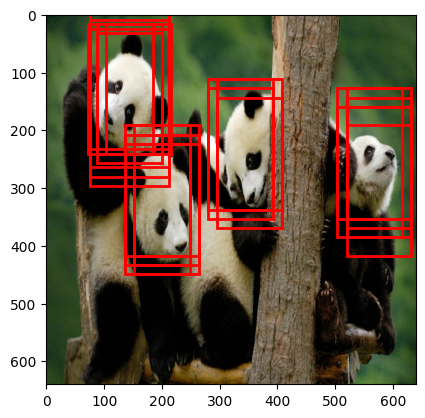

In [17]:
scales = np.array([10,12,32])
ratios = np.array([0.5,1,2])
new_size = [640,640]

anchor_boxes = generate_anchor_boxes(feature.shape[1:3], scales, ratios, new_size)
labels_target, regression_target, sample_idx, sample_pos_idx = data_load_rpn(scales, ratios, feature.shape[1:3], boxes, new_size)
pos_idx = sample_pos_idx.numpy()
plt.imshow(image[0])
for box in anchor_boxes[pos_idx]:
   rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
   plt.gca().add_patch(rect)
plt.show()

# Train with RPN model

In [18]:
def build_rpn(input_shape, num_anchor_boxs):
    input = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(input)

    bbox_regression = tf.keras.layers.Conv2D(4 * num_anchor_boxs, (1, 1), activation='linear', name= 'bbox_regression')(x)
    objectness_score = tf.keras.layers.Conv2D(num_anchor_boxs, (1, 1), activation='sigmoid', name='objectness_score')(x)

    model = tf.keras.Model(inputs=input, outputs=[bbox_regression,objectness_score])
    return model

In [45]:
# @tf.function
def training_loop(epochs, scales, ratios, feature, bboxes, new_size, n_pos=128, n_total=256, reset = True):
  #call model
  model = build_rpn(feature.shape[1:], len(scales) * len(ratios))
  #Define loss and otimizer
  smooth_l1_loss = tf.keras.losses.Huber(delta = 1.0, reduction = 'sum')
  classification_loss = tf.keras.losses.BinaryCrossentropy(from_logits = False)
  optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1) #learning_rate = 0.1
  loss_history = []

  for epoch in range(epochs):
    with tf.GradientTape() as tape:
      if reset:
        tape.reset()
        reset = False

      labels_target, regression_target, sample_idx, sample_pos_idx = data_load_rpn(scales, ratios, feature.shape[1:3], bboxes, new_size, n_pos, n_total)
      number_of_anchor = tf.shape(labels_target)[0]
      bbox_regression, objectness_score = model(feature)
      bbox_regression = tf.reshape(bbox_regression, (-1,4))
      objectness_score = tf.reshape(objectness_score, (-1))

        #Select samples index
      labels_target, objectness_score = tf.gather(labels_target, sample_idx), tf.gather(objectness_score, sample_idx)
      regression_target, bbox_regression = tf.gather(regression_target, sample_pos_idx), tf.gather(bbox_regression, sample_pos_idx)

        #Compute losses
      bbox_reg_loss = smooth_l1_loss(regression_target, bbox_regression) / tf.cast(number_of_anchor, dtype = tf.float32)
      cls_loss = classification_loss(labels_target, objectness_score)
      total_loss = bbox_reg_loss*10 + cls_loss

    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    loss_history.append(total_loss.numpy())

    if (epoch + 1) % 50 == 0:
        print('Epoch: ', epoch + 1, 'Total batch loss', total_loss.numpy())

  return loss_history, model

In [46]:
scales = np.array([10,12,32])
ratios = np.array([0.5,1,2])
new_size = [640,640]

loss, rpn_model = training_loop(500, scales, ratios, feature, boxes, new_size)

Epoch:  50 Total batch loss 0.018600807
Epoch:  100 Total batch loss 0.008323969
Epoch:  150 Total batch loss 0.0050358623
Epoch:  200 Total batch loss 0.003503713
Epoch:  250 Total batch loss 0.0026432064
Epoch:  300 Total batch loss 0.0021054593
Epoch:  350 Total batch loss 0.0017384007
Epoch:  400 Total batch loss 0.0014730147
Epoch:  450 Total batch loss 0.0012729139
Epoch:  500 Total batch loss 0.0011177264


0.0011177264 0.7623779
0.0011177264


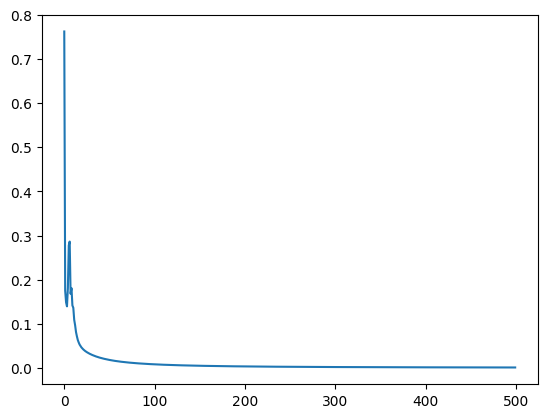

In [47]:
print(np.min(loss), np.max(loss))
print(loss[-1])
plt.plot(loss)
plt.show()

# Prediction

In [64]:
def regression_pred_into_anchor_or_proposals(anchors, prop_pred):
  pred_boxes = np.empty_like(prop_pred)
  #take the dx, dy, dw, dh
  dx = prop_pred[:,0]
  dy = prop_pred[:,1]
  dw = prop_pred[:,2]
  dh = prop_pred[:,3]

  #transform (xmin,ymin,xmax,ymax) into (xcenter, ycenter, width, height)
  anchors = coordinate_to_center(anchors)
  xcenter = anchors[:,0]
  ycenter = anchors[:,1]
  width = anchors[:,2]
  height = anchors[:,3]

  #Calcule xcenter, ycenter, width, height of predict boxes
  pred_boxes[:,0] = dx * width + xcenter
  pred_boxes[:,1] = dy * height + ycenter
  pred_boxes[:,2] = np.exp(dw) * width
  pred_boxes[:,3] = np.exp(dh) * height

  return pred_boxes #xcenter, ycenter, width, height

def clip_box(proposal, images_shape):
  proposal[:,0] = np.clip(proposal[:,0], 0, images_shape[0])
  proposal[:,1] = np.clip(proposal[:,1], 0, images_shape[1])
  proposal[:,2] = np.clip(proposal[:,2], 0, images_shape[0])
  proposal[:,3] = np.clip(proposal[:,3], 0, images_shape[1])
  return proposal

def mns_filter(proposal, cls_score, new_shape):
  top_n_idx = cls_score.argsort()[::-1][:10000]

  cls_score = cls_score[top_n_idx]
  proposal = proposal[top_n_idx]

  proposal = clip_box(proposal, new_shape)
  keep_mask = np.zeros_like(cls_score, dtype = bool)
  keep_ind = tf.image.non_max_suppression(proposal, cls_score, 2000, 0.7)

  keep_mask[keep_ind] = True
  keep_ind = np.where(keep_mask)[0]

  proposal = proposal[keep_ind]
  cls_score = cls_score[keep_ind]

  return proposal, cls_score

In [65]:
def choose_top(scales, ratios, feature, regression_pred, score_cls, new_size, threshold):
  anchor_boxes = generate_anchor_boxes(feature.shape[1:3], scales, ratios, new_size)
  proposals = regression_pred_into_anchor_or_proposals(anchor_boxes, regression_pred)
  proposals = center_to_coordinate(proposals)
  proposals, score = mns_filter(proposals, score_cls, new_size)
  idx_over_threshold = np.where(score >= threshold)[0]
  proposals = proposals[idx_over_threshold]
  return proposals

In [66]:
reg_prd, score_cls = rpn_model.predict(feature)
reg_prd = np.reshape(reg_prd, (feature.shape[0],-1,4))
score_cls = np.reshape(score_cls, (feature.shape[0],-1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


(91, 4)


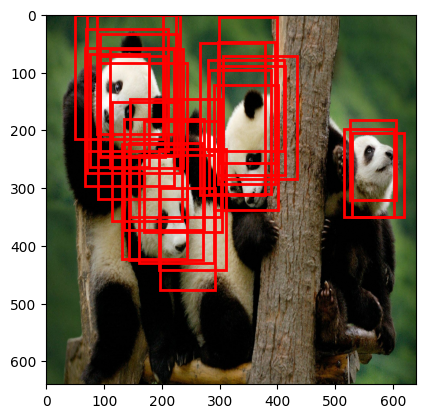

In [67]:
plt.imshow(image[0])

proposals = choose_top(scales, ratios, feature, reg_prd[0], score_cls[0], new_size, 0.8)
print(proposals.shape)

for box in proposals[:30]:
  rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
  plt.gca().add_patch(rect)

plt.show()